# Automatic Experiments Analysis

## Summary

This notebook presents the automatic analysis of experiments reported in ... **[PUT THE PAPER LINK]**.
Here, we provide functions to get experiments results from [OpenML](http://www.openml.org/) website, handle them, and output the charts depicted in the paper.


## 1. Setup

First, we need to install all the required packages. We will need a function called *checkPackages* located into the R subdir. This can be done with the following commands:

In [6]:
required_packages = c("devtools", "ggplot2", "reshape2", "gridExtra", "mlr", "dplyr", "data.table", "farff", "OpenML")
source("R/checkPackages.R")
checkPackages(pkgs = required_packages)

 - Package: devtools 	... is already installed
 - Package: ggplot2 	... is already installed
 - Package: reshape2 	... is already installed
 - Package: gridExtra 	... is already installed
 - Package: mlr 	... is already installed
 - Package: dplyr 	... is already installed
 - Package: data.table 	... is already installed
 - Package: farff 	... is already installed
 - Package: OpenML 	... is already installed


The function's code is simple, it just checks if you have the R package, if not it installs them from CRAN. The exceptions are the [OpenML](https://github.com/openml/openml-r) and [farff](https://github.com/mlr-org/farff) packages: they are installed from their github repos.

Once all the packages are installed, we need to load all of them via *'library'* command:

In [2]:
library("ggplot2")
library("reshape2")
library("gridExtra")
library("OpenML")
library("repr")
library("dtplyr")

Then, we need to setup the OpenML API to get the data and *farff* to read the data from the server :

In [3]:
# Please, replace the OpenML API key with your
setOMLConfig(arff.reader = "RWeka") # "farff"
#setOMLConfig(apikey = "")

OpenML configuration:
  server           : http://api_new.openml.org/v1
  cachedir         : /tmp/Rtmp2Aavk9/cache
  verbosity        : 0
  arff.reader      : RWeka
  confirm.upload   : FALSE
  apikey           : ***************************c6ae0

Finally, we need to load our required R scripts, with the plot functions. All of them are in the R subdir, located in the same folder as this file. This can be done like that:

In [113]:
# load all files from R subdir
files = list.files(path = "R/")
for (file in files) {
    sc = paste0("R/", file)
    cat(paste0("Loading file: ... ", sc, "\n"))
    source(sc)
}

Loading file: ... R/checkMeasure.R
Loading file: ... R/checkPackages.R
Loading file: ... R/config.R
Loading file: ... R/getAlgosAvgLinePlots.R
Loading file: ... R/getAvgPerformance.R
Loading file: ... R/getAvgRuntimeData.R
Loading file: ... R/getBoxPlot.R
Loading file: ... R/getExperimentsData.R
Loading file: ... R/getPercMaxPerfLinePlot.R
Loading file: ... R/getPerfMatrix.R
Loading file: ... R/getRankFrequencyPlot.R
Loading file: ... R/getRanking.R
Loading file: ... R/getRankingHeatMap.R
Loading file: ... R/getRuntimeLinePlot.R
Loading file: ... R/getTasksInfoPlot.R
Loading file: ... R/getViolinPlot.R
Loading file: ... R/matricesPlots.R
Loading file: ... R/scaleMatrix.R


## 2. Loading experiments data from OpenML

So, once everything was set up, let's load our data. We would need two parameters here:
* *tag* - the tag that identifies the study/experiment; and
* *numRuns* - the amount of runs executed

The following function, **getExperimentsData()**, will then return all *'numRuns'* run results with the specified *tag*. This data frame is already melted to be handled by our plot functions.


With this function we can then get the data from our study **14** using the command:

In [12]:
#data = getExperimentsData(tag = "study_14", numRuns = 10000)
data = getExperimentsData(tag = "study_14") 

It will return a R data frame object with the main characteristics of your runs. It should look like something like this:

In [13]:
head(data)

data.name,run.id,task.id,setup.id,flow.id,flow.name,average.cost,f.measure,f.measure.array,kappa,⋯,usercpu.time.millis.testing,usercpu.time.millis.training,area.under.roc.curve,area.under.roc.curve.array,data.id,NumberOfInstances,NumberOfFeatures,NumberOfClasses,MajorityClassSize,perMajClass
AP_Breast_Colon,1815682,3979,9370,4693,mlr.classif.naiveBayes.preproc.preproc,0,0.963373,"[0.967376,0.958559]",0.925989,,266.816,471.233,0.960674,"[0.960674,0.960674]",1145,630,10937,2,344,0.5460317
AP_Breast_Kidney,1815683,3992,9370,4693,mlr.classif.naiveBayes.preproc.preproc,0,0.973484,"[0.976879,0.968992]",0.945873,,243.771,416.269,0.972048,"[0.972048,0.972048]",1158,604,10937,2,344,0.5695364
AP_Breast_Ovary,1815685,3999,9370,4693,mlr.classif.naiveBayes.preproc.preproc,0,0.961530,"[0.968796,0.948905]",0.917768,,237.768,422.908,0.966261,"[0.966261,0.966261]",1165,542,10937,2,344,0.6346863
AP_Colon_Kidney,1815679,3971,9370,4693,mlr.classif.naiveBayes.preproc.preproc,0,0.972534,"[0.973638,0.971319]",0.944959,,220.160,396.271,0.972727,"[0.972727,0.972727]",1137,546,10937,2,286,0.5238095
Amazon_employee_access,1815732,34539,9370,4693,mlr.classif.naiveBayes.preproc.preproc,0,0.781508,"[0.213497,0.816411]",0.127976,,12.161,5.061,0.700261,"[0.700261,0.700261]",4135,32769,10,2,30872,0.9421099
Amazon_employee_access,1815606,34539,9369,4692,mlr.classif.rpart.preproc.preproc.tuned,0,0.928496,"[0.273232,0.96876]",0.247291,,0.943,435.624,0.590214,"[0.590214,0.590214]",4135,32769,10,2,30872,0.9421099


## 3. Getting tasks overview

The first analysis taht can be done is to generate an overview of the OpenML tasks used in experiments. The following function (**getTasksInfoPlot**) will receive a melted data frame and show general aspects of the OpenML tasks.

In the chart below, the x-axis represents all the OpenML tasks with runs in the experiment. The y-axis represents the peformance values. We have three kind of points here:
* **green dots** that indicate the maximum accuracy (*max_acc*) value reached in each task;
* **orange triangles** that indicate the maximum AUC (*max_auc*) value reached in each task; and
* **dark squares** that indicate the percentage of examples belonging to the majority class (*perc_maj*) in each task.

The plot is generated below. Passing your data as an argument will generate a similar plot for your tasks.

Warning message:
"Removed 3 rows containing missing values (geom_point)."

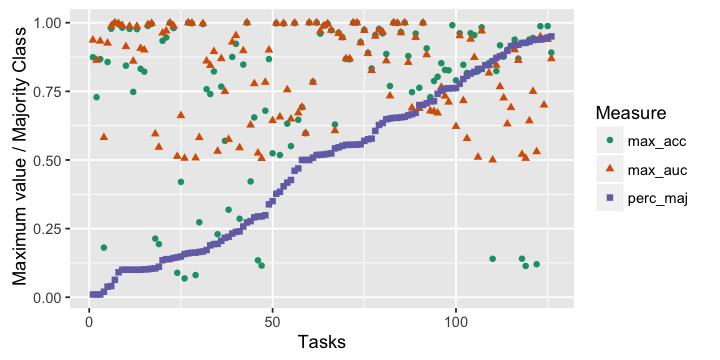

In [61]:
# Arguments:
#  * data: metled data frame return by getExperimentsData() function
# Output:
#  ggplot chart

getTasksInfoPlot = function(data) {

  tasks = unique(data$task.id)
  aux = lapply(tasks, function(task){
    sub = data[which(data$task.id == task), ]
    max.acc = max(sub$predictive.accuracy)
    max.auc = max(sub$area.under.roc.curve)
    maj.prop = max(sub$perMajClass)
    ret = c(max.acc, max.auc, maj.prop)
    return(ret)
  })

  # df = [task | max.acc | max.auc | % maj class ]
  df = data.frame(do.call("rbind", aux))
  colnames(df) = c("max_acc", "max_auc", "perc_maj")  
  df$tasks = tasks
  
  # sort increasing the % majclass (tasks)
  df = df[order(df$perc_maj, decreasing = FALSE),]
  df$tasks = factor(df$tasks, levels = df$tasks)

  df.final = melt(df, id.vars = 4)
  colnames(df.final) = c("task", "Measure", "value")
  df.final$task = as.numeric(df.final$task)
 
  g = ggplot(data=df.final, aes(x=task, y=value, group=Measure, colour=Measure, shape=Measure)) 
  g = g + geom_point() + scale_colour_brewer(palette = "Dark2")
  g = g + ylab(" Maximum value / Majority Class") + xlab("Tasks")
  g = g + scale_x_continuous(limits = c(1, nrow(df)))
 
  return(g)
}

# Calling the function and showing the chart
options(repr.plot.width=6, repr.plot.height=3)
getTasksInfoPlot(data = data)

## 4. Simple performance analysis

With the previously defined we can now do some basic performance comparisons and generate plots based on them, such as, line plots, box plots, heap maps, and son on.

But first, we need to generate the a performance matrix according to a specific evaluation measure. Here, we are  generating the plots based on `measure = 'predictive.accuracy'`.

In [18]:
# Getting the performance matrix
mat.acc = getPerfMatrix(data = data, measure = "predictive.accuracy")
head(mat.acc)


 - Getting performance matrix for: predictive.accuracy


,mlr.classif.naiveBayes.preproc.preproc,mlr.classif.rpart.preproc.preproc.tuned,mlr.classif.svm.preproc.preproc.tuned,mlr.classif.gbm.preproc.preproc.tuned,mlr.classif.kknn.preproc.preproc.tuned,mlr.classif.glmnet.preproc.preproc.tuned,mlr.classif.ranger.preproc.preproc.tuned
3979,0.963492,NA,NA,NA,NA,NA,NA
3992,0.973510,NA,NA,NA,NA,NA,NA
3999,0.961255,NA,NA,NA,NA,NA,NA
3971,0.972527,NA,NA,NA,NA,NA,NA
34539,0.702310,0.940096,NA,NA,NA,NA,NA
3019,0.798551,0.844928,0.856522,0.86087,0.853623,0.868116,0.86087


The cells that present 'NA' values mean that the algorithm failed, for some reason, to fit a model in that task.

Now, with the performance matrix we can generate the ranking via the **getRanking** function. It will return an object with two slots:
* *rk* : is a matrix where each cell contains the algorithms ranking for a specific task; and 
* *rk.avg*: is the average ranking for all the algorithms evaluated over all the tasks.

Examples are shown in the commands below.

In [19]:
# Getting the accuracy rankings
rk.acc  = getRanking(mat.acc,  descending = TRUE)
head(rk.acc$rk)

,mlr.classif.naiveBayes.preproc.preproc,mlr.classif.rpart.preproc.preproc.tuned,mlr.classif.svm.preproc.preproc.tuned,mlr.classif.gbm.preproc.preproc.tuned,mlr.classif.kknn.preproc.preproc.tuned,mlr.classif.glmnet.preproc.preproc.tuned,mlr.classif.ranger.preproc.preproc.tuned
3979,1,NA,NA,NA,NA,NA,NA
3992,1,NA,NA,NA,NA,NA,NA
3999,1,NA,NA,NA,NA,NA,NA
3971,1,NA,NA,NA,NA,NA,NA
34539,2,1,NA,NA,NA,NA,NA
3019,7,6,4,2.5,5,1,2.5


In [21]:
# Average rk values for each learner
head(rk.acc$rk.avg)

alg,rk.avg
mlr.classif.naiveBayes.preproc.preproc,4.087302
mlr.classif.rpart.preproc.preproc.tuned,3.960227
mlr.classif.svm.preproc.preproc.tuned,2.209877
mlr.classif.gbm.preproc.preproc.tuned,2.538462
mlr.classif.kknn.preproc.preproc.tuned,3.783951
mlr.classif.glmnet.preproc.preproc.tuned,4.018987


### a) Box plot
First we can check some box plot and have an overview how algorithms perform in our benchmark datasets. It can be done using the **getBoxPlot** specifying the performance measure that we want to analyze. The parameters needed as arguments are: the melted data frame returned from *getExperimentsData* function, the performance measure and the output layout (portrair or landscap).



Warning message:
"Removed 1 rows containing non-finite values (stat_boxplot)."Warning message:
"Removed 1 rows containing non-finite values (stat_boxplot)."

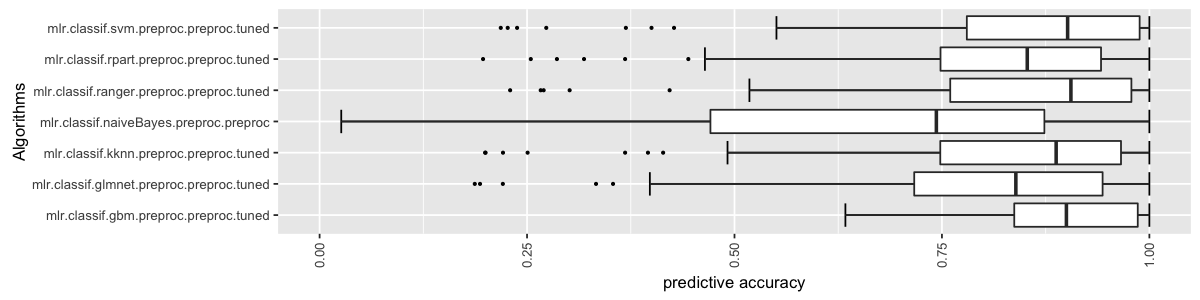

In [62]:
options(repr.plot.width=10, repr.plot.height=2.5)
getBoxPlot(data = data, measure = "predictive.accuracy", landscape = TRUE)
# getBoxPlot(data = data, measure = "usercpu.time.millis")
# getBoxPlot(data = data, measure = "usercpu.time.millis.training")
# getBoxPlot(data = data, measure = "usercpu.time.millis.testing")
# getBoxPlot(data = data, measure = "f.measure")
# getBoxPlot(data = data, measure = "kappa")

### B) Violin plot

The violin plot is a similar analysis to box plots, except that they also show the probability density of the values. We can generate them based on the melted data frame, specifying the measure, and the design to export the chart (portrair or landscape).


Warning message:
"Removed 1 rows containing non-finite values (stat_ydensity)."Warning message:
"Removed 1 rows containing non-finite values (stat_boxplot)."

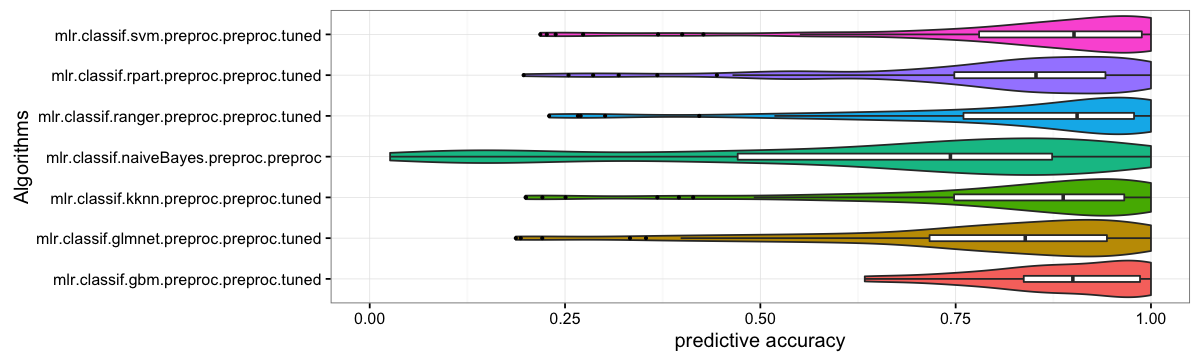

In [89]:
options(repr.plot.width=10, repr.plot.height=3)
getViolinPlot(data, measure = "predictive.accuracy")
# getViolinPlot(data, measure = "area.under.roc.curve")
# getViolinPlot(data, measure = "f.measure")
# getViolinPlot(data, measure = "usercpu.time.millis")


### c) Ranking heat map

The function **getRankingHeatMap** gives a global vision of the ranks obtained in each task. It receives a matrix, returned by the **getRanking** function, and plot a gray-scale heat-map. Lighter the values, better are the learners, corresponding to the best rank positions. The *salmon* cells show the runs that crashed in some way, i.e., there is no result for that combination of ```{algorithm, task}```.


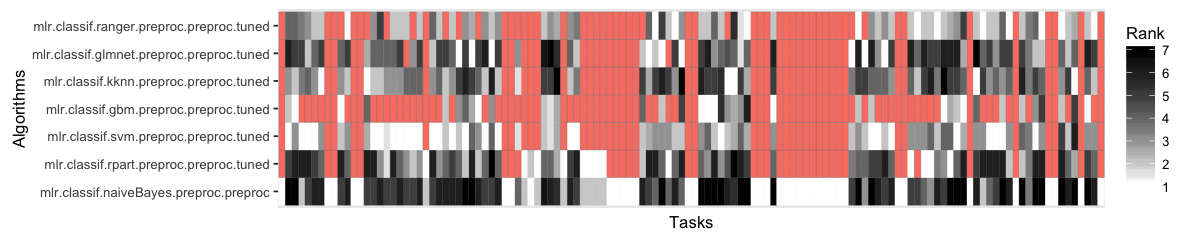

In [114]:
# ranking frequency
rk.acc   = getRanking(mat.acc, descending = TRUE)
#rk.auc   = getRanking(mat.auc, descending = TRUE) 
#rk.f1    = getRanking(mat.f1, descending = TRUE)
#rk.acc.w = getRanking(mat.acc.w, descending = TRUE) 
#rk.time  = getRanking(mat.runtime, descending = FALSE)

# Calling the function and showing the chart
options(repr.plot.width=10, repr.plot.height=2)
getRankingHeatMap(data = rk.acc$rk)

 

### d) Ranking frequency

Tthe "*ranking frequency*" plot shows how many times (or the percentage of occurrences) each algorithm appears in the **k** first rank positions. Is also uses the runtime to "*penalize*" them, i.e., more red the bar, more time consuming is the algorith. On the other hand, more gray, more fast it is.

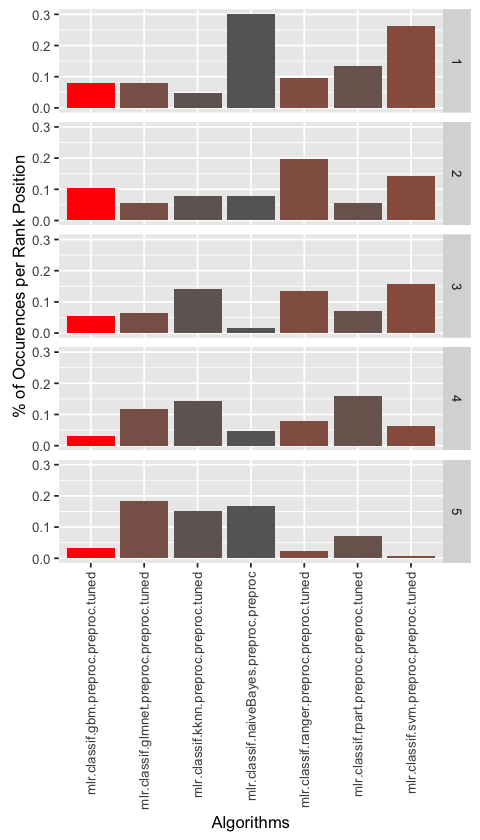

In [68]:
# Arguments:
#  * rk: the ranking generated by getRanking() function
#  * data: metled data frame return by getExperimentsData() function
#  * k: number of positions to be considered in the plot (k-rank)
#  * version: using absolute of percentage values

# Calling the function and showing the chart
options(repr.plot.width=4, repr.plot.height=7)
getRankFrequencyPlot(rk = rk.acc, data = data, k = 5, version = "percentage")  

## 5. Runtime Analysis

Evaluating the runtime information basically use the same R basic functions. First, we also need to generate the runtime matrix and the average rankings.

In [48]:
runtime.data = getAvgRuntimeData(data = data)
head(runtime.data)

usercpu.time.millis.training,usercpu.time.millis.testing,usercpu.time.millis,alg
103.6851,161.5716429,265.2567,mlr.classif.naiveBayes.preproc.preproc
4332.5042,1.6252500,4334.1295,mlr.classif.rpart.preproc.preproc.tuned
11050.1979,2.3189259,11052.5169,mlr.classif.svm.preproc.preproc.tuned
39753.2782,1.3217949,39754.6000,mlr.classif.gbm.preproc.preproc.tuned
2319.9347,2.2524321,2322.1871,mlr.classif.kknn.preproc.preproc.tuned
7524.9912,0.7474684,7525.7387,mlr.classif.glmnet.preproc.preproc.tuned


### a) Line plot

The first analysis regarding runtime shows a line plot with the average {training, testing and total} runtimes. 
The algorithms are ascending order according to the average total runtime {training + testing time}. The x-axis presents each algorithm while the y-axis shows the average runtime values (in the log scale).

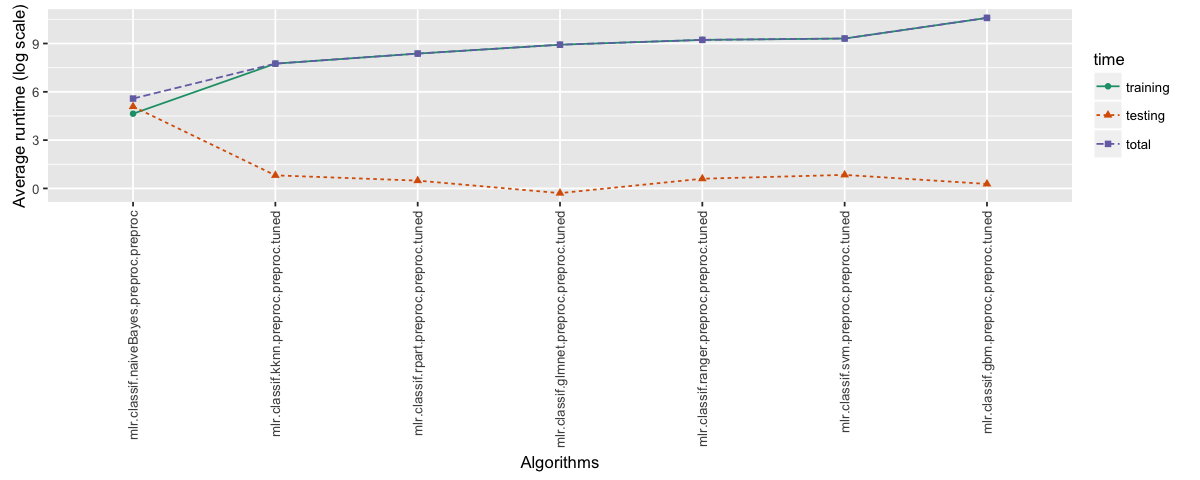

In [52]:
# Arguments
#  * data: metled data frame return by getExperimentsData() function
# Output:
#  * ggplot chart

options(repr.plot.width=10, repr.plot.height=4)
getRuntimeLinePlot(runtime.data = runtime.data)

### b) Box Plot

Like with the accuracies, we also can generate the boxplot regarding runtimes. It receives the melted data frame and returns the plot. It is possible to choose in which design (portrait or landscape) the chart will be exported/generated.

Warning message:
"Removed 1 rows containing non-finite values (stat_boxplot)."Warning message:
"Removed 1 rows containing non-finite values (stat_boxplot)."

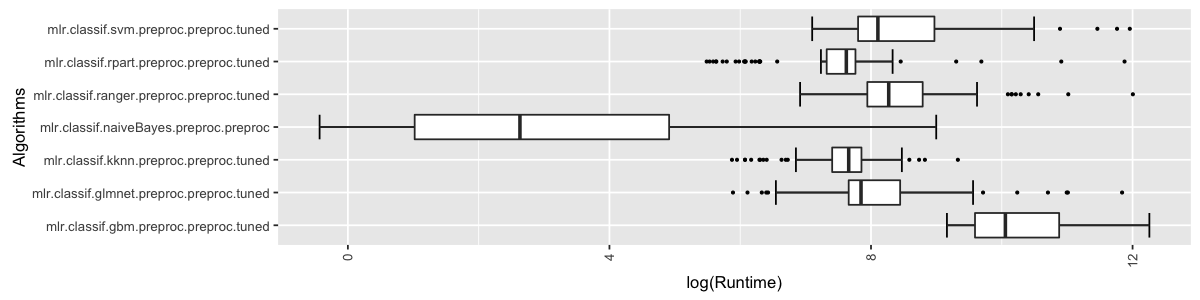

In [86]:
# Arguments:
#  * data: metled data frame return by getExperimentsData() function
#  * landscape: flip the coordinates of the chart and print it in a ladscape design (default is FALSE)
# Output:
#  * ggplot chart

options(repr.plot.width=10, repr.plot.height=2.5)
getBoxPlot(data = data, measure = "usercpu.time.millis", landscape = TRUE)

### c) Violin Plot
Or even, we can generate a violin plot:

Warning message:
"Removed 1 rows containing non-finite values (stat_ydensity)."Warning message:
"Removed 1 rows containing non-finite values (stat_boxplot)."

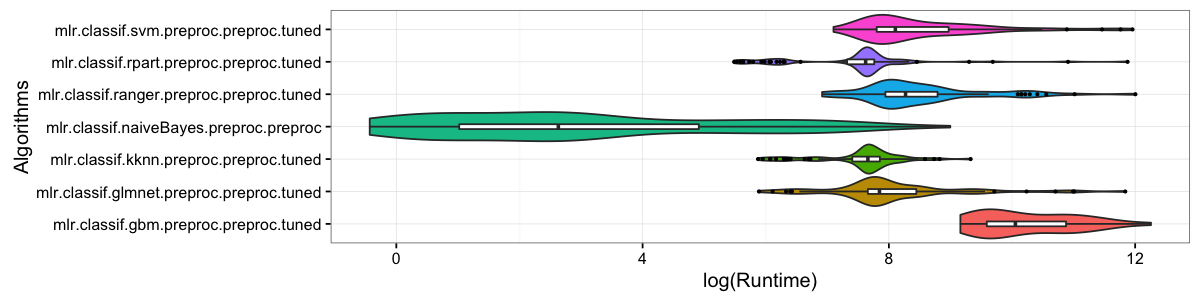

In [85]:
options(repr.plot.width=10, repr.plot.height=2.5)
getViolinPlot(data = data, measure = "usercpu.time.millis", landscape = TRUE)

### d) Ranking heatmap plot

Basically, plots a heap map with the a global overview of the rankings. Darker the cell, better was the learner (faster) in that task.



In [73]:
mat.time = getPerfMatrix(data = data, measure = "usercpu.time.millis")
rk.time  = getRanking(mat.time, descending = FALSE)
head(rk.time$rk)

 - Getting performance matrix for: usercpu.time.millis


,mlr.classif.naiveBayes.preproc.preproc,mlr.classif.rpart.preproc.preproc.tuned,mlr.classif.svm.preproc.preproc.tuned,mlr.classif.gbm.preproc.preproc.tuned,mlr.classif.kknn.preproc.preproc.tuned,mlr.classif.glmnet.preproc.preproc.tuned,mlr.classif.ranger.preproc.preproc.tuned
3979,1,NA,NA,NA,NA,NA,NA
3992,1,NA,NA,NA,NA,NA,NA
3999,1,NA,NA,NA,NA,NA,NA
3971,1,NA,NA,NA,NA,NA,NA
34539,1,2,NA,NA,NA,NA,NA
3019,1,2,5,7,3,4,6


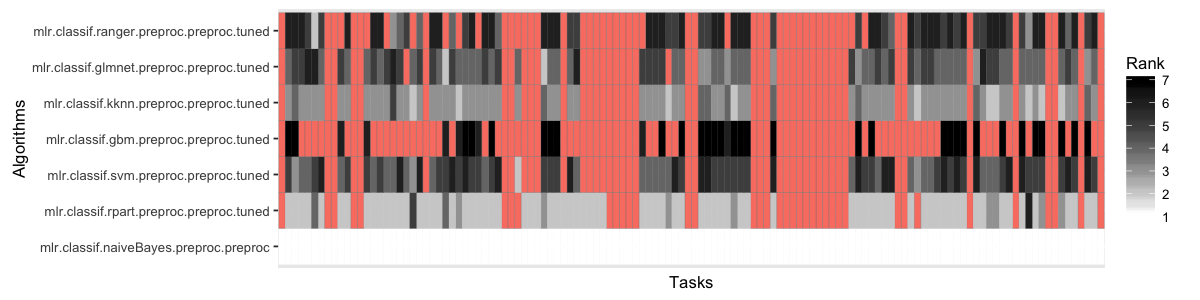

In [115]:
# Calling the function and showing the chart
options(repr.plot.width=10, repr.plot.height=2.5)
getRankingHeatMap(data = rk.time$rk)
   

## 6. Maximum Performance Analysis

The same can be generated for the scaled matrices, i.e., performance matrices scaled according to the best performance on each individual task. They can be computed using the **scaleMatrix** function, and passed as an argument to the ploting functions.

In [77]:
# Scaling data
scaled.mat.acc = scaleMatrix(mat = mat.acc)
# scaled.mat.auc = scaleMatrix(mat = mat.auc)
# scaled.mat.runtime = scaleMatrix(mat = mat.runtime)
head(scaled.mat.acc)

,mlr.classif.naiveBayes.preproc.preproc,mlr.classif.rpart.preproc.preproc.tuned,mlr.classif.svm.preproc.preproc.tuned,mlr.classif.gbm.preproc.preproc.tuned,mlr.classif.kknn.preproc.preproc.tuned,mlr.classif.glmnet.preproc.preproc.tuned,mlr.classif.ranger.preproc.preproc.tuned
3979,1.0000000,NA,NA,NA,NA,NA,NA
3992,1.0000000,NA,NA,NA,NA,NA,NA
3999,1.0000000,NA,NA,NA,NA,NA,NA
3971,1.0000000,NA,NA,NA,NA,NA,NA
34539,0.7470620,1.0000000,NA,NA,NA,NA,NA
3019,0.9198667,0.9732893,0.9866446,0.9916532,0.9833052,1,0.9916532


### a) Box plot

No id variables; using all as measure variables


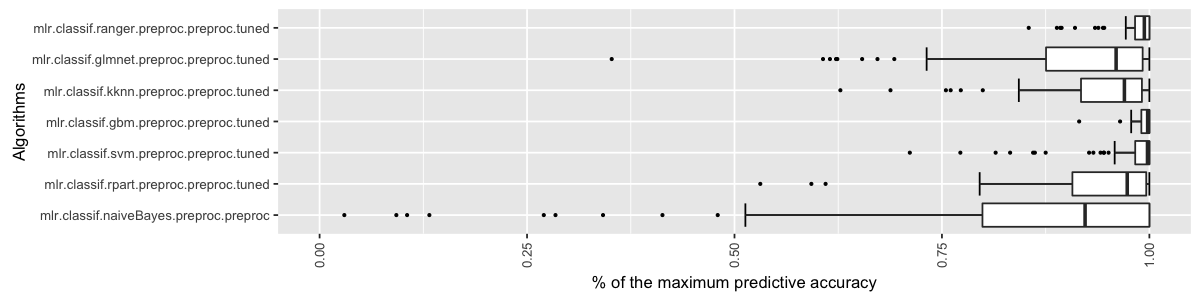

In [109]:
options(repr.plot.width=10, repr.plot.height=2.5)
getMatrixBoxPlot(mat = scaled.mat.acc, prefix = "predictive accuracy", landscape = TRUE)

### b) Violin Plot

No id variables; using all as measure variables


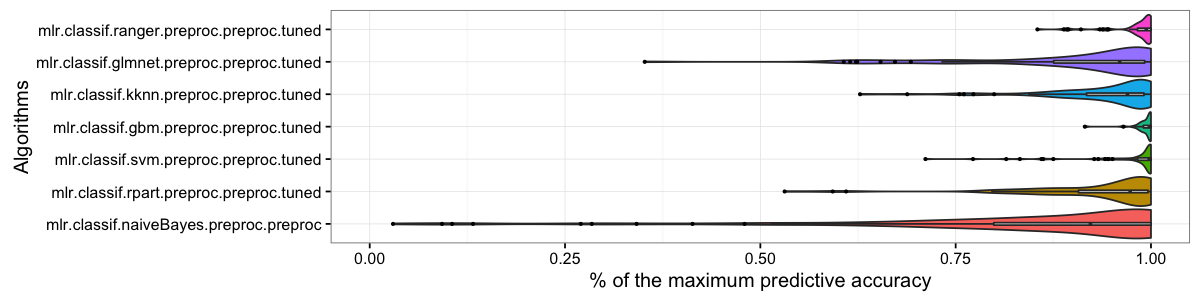

In [110]:
options(repr.plot.width=10, repr.plot.height=2.5)
getMatrixViolinPlot(mat = scaled.mat.acc, prefix = "predictive accuracy", landscape = TRUE)

### c) Ranking Heat Map Plot

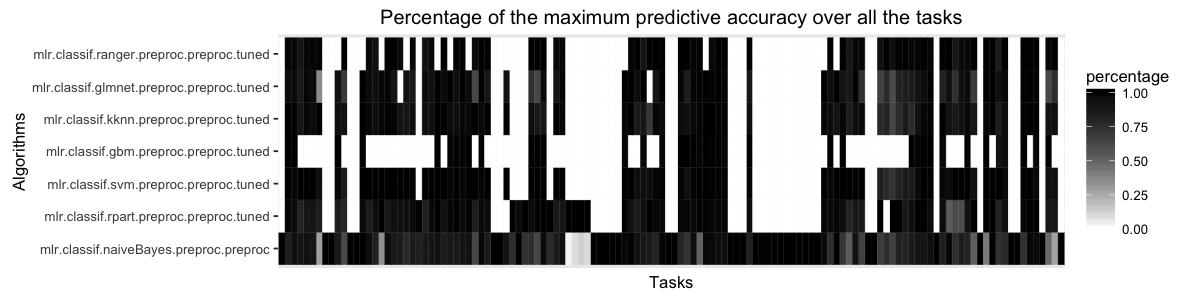

In [117]:
options(repr.plot.width=10, repr.plot.height=2.5)
getMatrixHeatMap(mat = scaled.mat.acc,    prefix = "predictive accuracy")

## 7. Multiple analysis

Comparing average performances and average ranking values ...

Using algo as id variables


 - Getting performance matrix for: predictive.accuracy
 - Getting performance matrix for: area.under.roc.curve
 - Getting performance matrix for: f.measure
 - Getting performance matrix for: recall
 - Getting performance matrix for: precision
 - Getting performance matrix for: kappa


Using algo as id variables


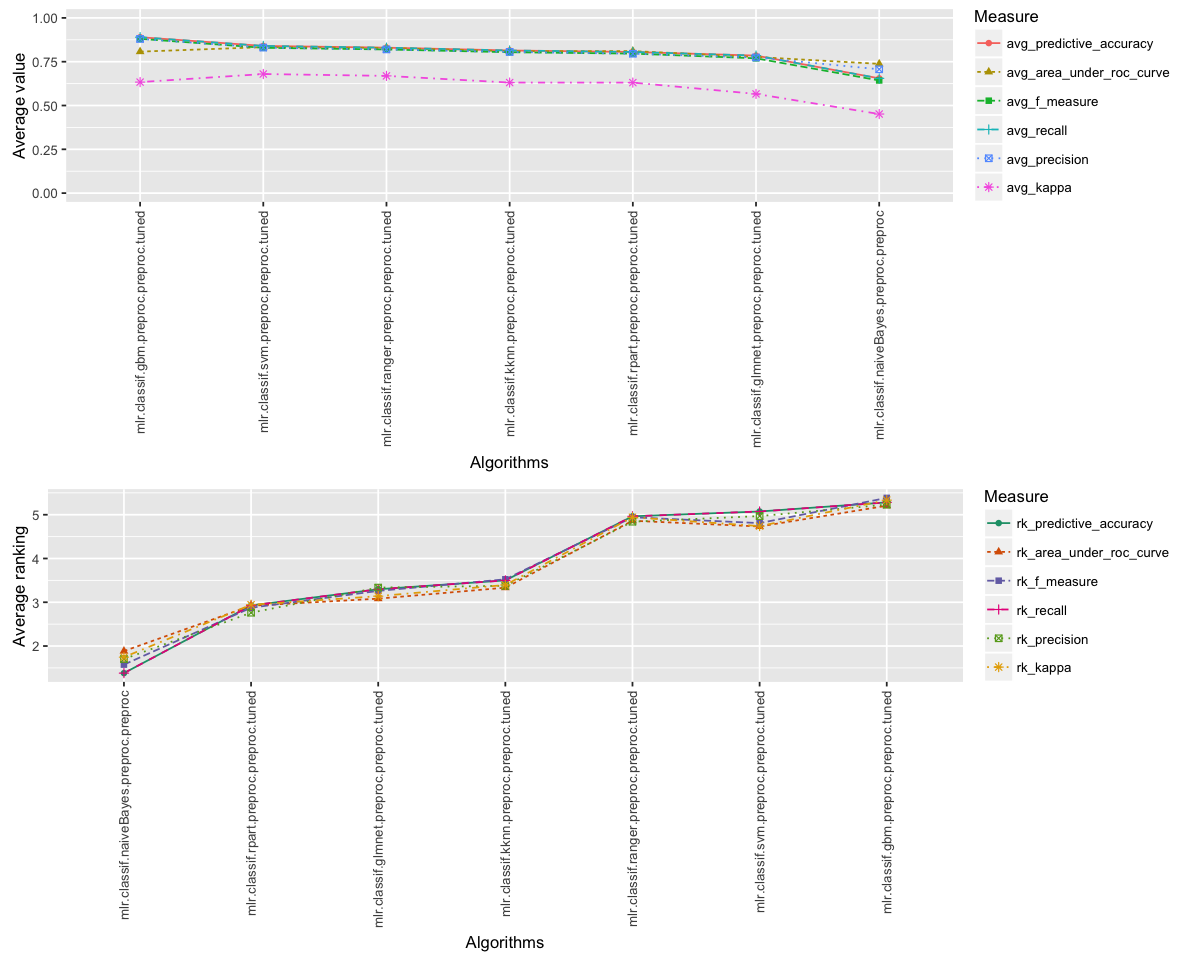

In [112]:
measures.list = list("predictive.accuracy", "area.under.roc.curve", "f.measure", "recall", "precision", "kappa")

g1 = getAlgosAvgPerfLinePlot(data = data, measures.list = measures.list)
g2 = getAlgosAvgRankLinePlot(data = data, measures.list = measures.list)

options(repr.plot.width=10, repr.plot.height=8)
gridExtra::grid.arrange(g1, g2, ncol = 1, nrow = 2)

 - Getting performance matrix for: predictive.accuracy
 - Getting performance matrix for: area.under.roc.curve
 - Getting performance matrix for: f.measure
 - Getting performance matrix for: kappa
 - Getting performance matrix for: precision
 - Getting performance matrix for: recall


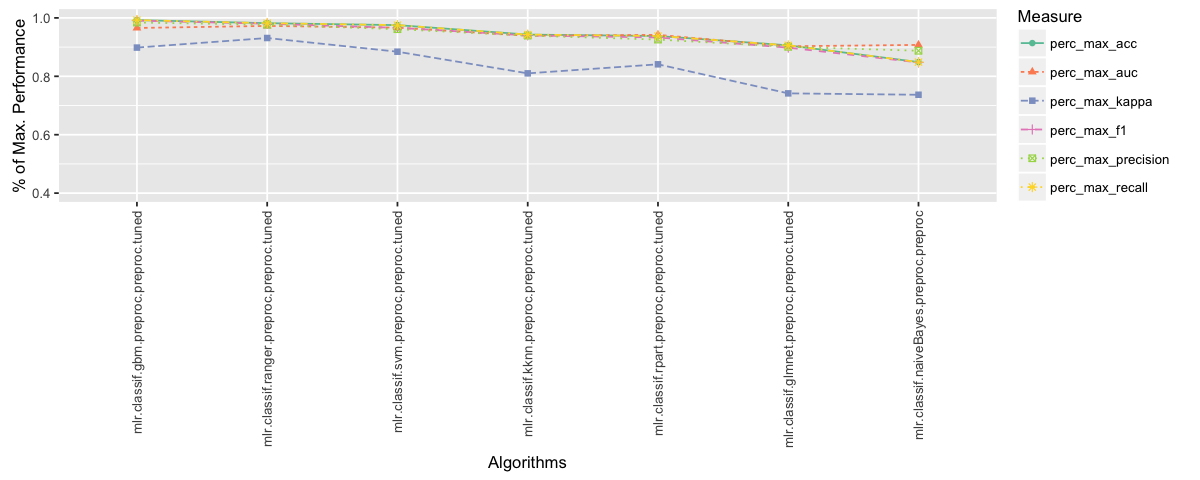

In [108]:
mat.acc       = getPerfMatrix(data = data, measure = "predictive.accuracy")
mat.auc       = getPerfMatrix(data = data, measure = "area.under.roc.curve")
mat.f1        = getPerfMatrix(data = data, measure = "f.measure")
mat.kappa     = getPerfMatrix(data = data, measure = "kappa")
mat.precision = getPerfMatrix(data = data, measure = "precision")
mat.recall    = getPerfMatrix(data = data, measure = "recall")

matrices.list = list(mat.acc, mat.auc, mat.kappa, mat.f1, mat.precision, mat.recall) 
measures.names = c("acc", "auc", "kappa", "f1", "precision", "recall")  

options(repr.plot.width=10, repr.plot.height=4)
getPercMaxPerfLinePlot(matrices.list = matrices.list, measures.names = measures.names)


## Recap

...

If you want you can reproduce the analysis using a different performance measure.